<a href="https://colab.research.google.com/github/erezimm/ML-ML/blob/master/GNN_final_project_ofek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main notebook, to be run on Google Colab

## Import dependencies and download dataset

In [1]:
!pip install dgl

import glob
import os
import shutil
from datetime import datetime

import astropy.io.ascii
import dgl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

if not torch.cuda.is_available():
    raise Exception('Cuda unavailable, turn it on under Runtime>Change runtime type>GPU')
device = torch.device('cpu')

training_path = '/content/training_set'
validation_path = '/content/validation_set'
for path in (training_path, validation_path):
    if not os.path.isdir(path):
        os.makedirs(path)

!wget -O data.zip https://github.com/erezimm/ML-ML/raw/master/data.zip
!unzip -o -q data.zip -d /content/
data_path = '/content/data'
microlist = glob.glob(data_path+'/microlensedconst_*')
varlist = glob.glob(data_path+'/cleanvar_*')
for typelist in (microlist, varlist):
    for i, f in enumerate(typelist):
        dest = training_path if i<len(microlist)/2 else validation_path
        shutil.move(f, os.path.join(dest, os.path.basename(f)))

     |████████████████████████████████| 3.0MB 3.4MB/s 


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
--2020-08-09 09:55:20--  https://github.com/erezimm/ML-ML/raw/master/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/erezimm/ML-ML/master/data.zip [following]
--2020-08-09 09:55:21--  https://raw.githubusercontent.com/erezimm/ML-ML/master/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6541642 (6.2M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>

## Create Datasets
Class CustomDataset loads all files and converts them to a list of graphs.
Each node in a graph is a data point, i.e. node features are days since start, mag, magerr

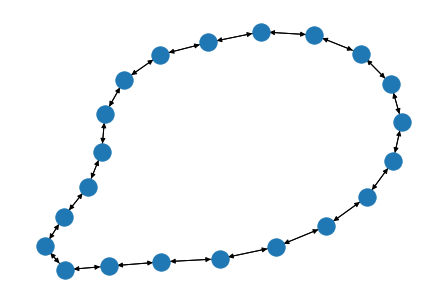

In [2]:
class CustomDataset(Dataset):
    def __init__(self, path):
        filelist = glob.glob(path+'/*')
        
        self.graphs = []
        self.isMicrolensed = []
        for fname in tqdm(filelist):
            filebasename = os.path.basename(fname)
            if filebasename.startswith('cleanvar'):
                microlensed = torch.tensor([0])
            elif filebasename.startswith('microlensedconst'):
                microlensed = torch.tensor([1])
            else:
                raise Exception('Filename ' + fname + ' not clean_* or microlensed_*')
            
            with open(fname) as f:
                data = astropy.io.ascii.read(f.read())
                times, mags, magerrs = data['col1'], [], data['col3']
                for m, err in zip(data['col2'], magerrs):
                    mags.append(round(m, len(str(err).split('.')[1])))
                zipped = list(zip(times, mags, magerrs))
                zipped.sort(key=lambda tup: tup[0])
                times, mags, magerrs = zip(*zipped)

                n = len(times)
                g = dgl.DGLGraph()
                g.add_nodes(n)
                g.ndata['time'] = torch.tensor(times).float()  # days
                g.ndata['mag'] = torch.tensor(mags).float()
                g.ndata['magerr'] = torch.tensor(magerrs).float()
                g.add_edges([i for i in range(n)], [(i+1)%n for i in range(n)])
                g.add_edges([i for i in range(n)], [(i-1)%n for i in range(n)])
                
                self.graphs.append(g)
                self.isMicrolensed.append(microlensed)
        
    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.isMicrolensed[idx]


train_ds = CustomDataset(training_path)
validation_ds = CustomDataset(validation_path)

nx.draw(dgl.to_networkx(train_ds[20][0]))

In [3]:
def collate(samples):
    # The input `samples` is a list, a batch of whatever comes out of your dataset object
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    
    batched_graph = dgl.batch(graphs, node_attrs=['time', 'mag', 'magerr'])
    targets = torch.cat(labels)
    
    return batched_graph, targets.unsqueeze(1).float()

## The Newtwork

In [4]:
n_ft = 3  # number of node features (time, mag, magerr)

class EdgeNetwork(nn.Module):
    def __init__(self, node_hidrep, edge_hidrep):
        super(EdgeNetwork, self).__init__()
        n_in = 2*node_hidrep
        
        # network:
        sizes = [n_in] + [] + [edge_hidrep]

        layers = []
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()])
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        input = torch.cat((x.dst['node_hidrep'], x.src['node_hidrep']), dim=1)
        output = self.network(input)
        return {'edge_hidrep': output }

    
class NodeNetwork(nn.Module):
    def __init__(self, node_hidrep, edge_hidrep):
        super(NodeNetwork, self).__init__()
        n_in = edge_hidrep + node_hidrep

        # network:
        sizes = [n_in] + [10] + [node_hidrep]

        layers = []
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), nn.ReLU()])
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        mb = torch.mean( x.mailbox['edge_hidrep'] , dim=1 )
        input = torch.cat((mb, x.data['node_hidrep']), dim=1)
        out = self.network(input)
        return {'node_hidrep': out }


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        # networks:
        node_hidrep, edge_hidrep = 10, 10
        sizes_nodeinit = [n_ft] + [] + [node_hidrep]
        self.update_loop_length = 20

        layers = []
        for i in range(len(sizes_nodeinit)-1):
            layers.extend([nn.Linear(sizes_nodeinit[i], sizes_nodeinit[i+1]), nn.ReLU()])
        self.node_init = nn.Sequential(*layers)
        self.edge_network = EdgeNetwork(node_hidrep, edge_hidrep)
        self.node_network = NodeNetwork(node_hidrep, edge_hidrep)
        
    def forward(self, g):
        # OFEK use times starting from t=0 days, fluxes devided by median
        times = g.ndata['time'] - min(g.ndata['time'])
        flux = 10 ** (g.ndata['mag']/(-2.5))
        medflux = torch.median(flux)
        flux = flux/medflux
        fluxerr = flux * g.ndata['magerr'] * np.log(10) * 0.4 / medflux

        features = torch.tensor(list(zip(times, flux, fluxerr)))
        g.ndata['node_hidrep'] = self.node_init(features)

        for i in range(self.update_loop_length):
            g.update_all(self.edge_network, self.node_network)
        
        # OFEK changed max to mean
        output = dgl.mean_nodes(g, 'node_hidrep')  # maybe you can apply functions with dgl.function ?
        output = torch.mean(output, 1, keepdim=True)  # torch.max(output, 1, keepdim=True)[0]
        return output

## Train

In [5]:
def evaluate(net, validation_ds):
    test_data_loader = DataLoader(validation_ds, batch_size=30, shuffle=True, collate_fn=collate)

    net.cpu()
    net.eval()

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    total_positives = 0
    total_negatives = 0

    for i, (x,y) in enumerate(test_data_loader):
            y = y.data.numpy()
            prediction = net(x).cpu().data.numpy()
            
            prediction[prediction >= 0.5] = 1
            prediction[prediction <0.5] = 0
            
            total_positives+=len(np.where( y==1 )[0])
            total_negatives+=len(np.where( y==0 )[0])
            
            true_positive+= len(np.where( (prediction==y) & (y==1) )[0])
            # true_negative+= len(np.where( (prediction==y) & (y==0) )[0])
            false_positive+= len(np.where( (prediction!=y) & (y==0) )[0])
            # false_negative+= len(np.where( (prediction!=y) & (y==1) )[0])
                    
    print('Probability of detection:', true_positive/total_positives)  # probability of recognizing a microlensing when you see it
    print('Probability of false alarm:', false_positive/total_negatives)  # probability for misclassification of a variable star as microlensing

In [6]:
net = Classifier()
net.to(device)

Classifier(
  (node_init): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): ReLU()
    )
  )
)

In [7]:
# options:
# loss_func = nn.BCEWithLogitsLoss()
# loss_func = nn.L1Loss()
loss_func = nn.CrossEntropyLoss()
# optimizer = optim.Adadelta(net.parameters(), lr=0.1)
# optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = optim.Adam(net.parameters(), lr=0.001)
n_epochs = 50

losses = []

data_loader = DataLoader(train_ds, batch_size=30, shuffle=True, collate_fn=collate)
for epoch in tqdm(range(n_epochs)):
    net.train()
    this_losses = []
    for x,y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = net(x)
        output = torch.cat((1-output, output), dim=1)
        loss = loss_func(output.squeeze(), y.long().squeeze())
        this_losses.append(float(loss))
        loss.backward()
        optimizer.step()

    losses.append(np.mean(this_losses))
    print('Epoch:', epoch, 'Loss:', round(losses[-1], 4))  # for some real-time indication (couldn't manage to get this to dynamically plot)


# plot the printed losses:
losses = np.array(losses)
plt.plot(losses[1:],label='training loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

evaluate(net, validation_ds)  # show P_D, P_FA

Epoch: 0 Loss: 0.7305
Epoch: 1 Loss: 0.6939
Epoch: 2 Loss: 0.6935
Epoch: 3 Loss: 0.6933
Epoch: 4 Loss: 0.6937
Epoch: 5 Loss: 0.6934
Epoch: 6 Loss: 0.6935
Epoch: 7 Loss: 0.6934
Epoch: 8 Loss: 0.6935
Epoch: 9 Loss: 0.6935
Epoch: 10 Loss: 0.6934
Epoch: 11 Loss: 0.6937
Epoch: 12 Loss: 0.6937
Epoch: 13 Loss: 0.694
Epoch: 14 Loss: 0.6935
Epoch: 15 Loss: 0.6938
Epoch: 16 Loss: 0.6933
Epoch: 17 Loss: 0.6937
Epoch: 18 Loss: 0.6935
Epoch: 19 Loss: 0.6936


KeyboardInterrupt: ignored

## Save
Don't forget to download

In [ ]:
timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
torch.save(net.state_dict(), 'model_' + timestamp + '.pt')